# Predicting Life Expectancy and Quality of Life

### Question 1: How can we predict life expectancy and which factors are most influential in this prediction?

#### Author: Meghan Holquist
#### Date: 4/30/2023


## Overview

The first topic we're interested in is predicting life expectancy, thus our target variable for this question is "life expectancy raw value". To evaluate this question, we will build several different models, tune each one, and then evaluate which model performs the best so we can use it to predict life expectancy. We will then examine the feature importances or the coefficients (depending on the final model) to see which factors were most influential in predicting life expectancy. 


## Table of Contents
1. Identifying Target and Splitting Data 
2. Model Tuning
- 2.1 Linear Regression
- 2.2 Regularized Regression 
- 2.3 Random Forest Regressor
- 2.4 Gradient Boost Regressor

3. Model Selection
4. Final Model
5. Conclusions 


In [114]:
#import all relevant packages. 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score 
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from IPython.display import Image

%matplotlib inline

In [115]:
seed = 12

In [116]:
#read in our dataset 
county_health = pd.read_csv('data/df_clean.csv')
county_health.head()

,state fips code,county fips code,5-digit fips code,state abbreviation,name,release year,% 65 and older raw value,% below 18 years of age raw value,% female,% not proficient in english raw value,...,severe housing problems raw value,sexually transmitted infections raw value,social associations raw value,some college raw value,teen births raw value,unemployment raw value,uninsured adults raw value,uninsured children raw value,uninsured raw value,quality of life
0,1,1,1001,AL,Autauga County,2019,0.151196,0.239370,0.513422,0.008285,...,0.149546,341.2,12.631731,0.608547,26.524208,0.038635,0.109611,0.024762,0.085010,4.253659
1,1,3,1003,AL,Baldwin County,2019,0.199470,0.218485,0.514528,0.004545,...,0.138317,338.8,10.692213,0.661339,29.594009,0.039883,0.135703,0.032380,0.106993,4.174198
2,1,5,1005,AL,Barbour County,2019,0.188247,0.207638,0.472299,0.011993,...,0.154555,557.9,8.472944,0.367740,45.092838,0.059009,0.165422,0.029014,0.125132,4.851216
3,1,7,1007,AL,Bibb County,2019,0.160226,0.206061,0.464531,0.003943,...,0.109609,302.1,10.157665,0.484063,45.454545,0.043851,0.122973,0.026194,0.096801,4.339544
4,1,9,1009,AL,Blount County,2019,0.178426,0.233499,0.506886,0.018700,...,0.104012,114.3,9.011507,0.544140,35.600555,0.040214,0.155646,0.034301,0.121140,4.607176


## 1. Splitting Data & Pre-Processing 
Now that we have read in our dataset, it is time to split our data. First we need to split it into X and y. Our target variable for this question is life expectancy, so that will be our y. For our predictors, we will exclude any column that functions as an id for our data. We will also exclude the quality of life variable since it is a function of 2 existing variables in our dataset. Furthermore, since we are not trying to predict life expectancy in a particular year, we can include the year column in our modeling. We will include all other variables (including those that are highly correlated with life expectancy) to let the model decide how to deal with those. Therefore, we will exclude the following columns from our X set: 
- Quality of life
- 5-digit fips code
- county fips code
- state fips code
- name
- state abbreviation

After looking at the head of our data, there appear to be differing magnitudes across columns, so we will need to standardize our data prior to any modelling. Additionally, regualirized regressison models require standardization because there are differing magnitudes among predictors and this will impact the penalties. Since I want to be able to accurately compare all models, I will need to standardize my data and use that for all of the different models.   Since our data is all numeric, this is all the pre-processing we will need to perform. We will choose to split our data into training and testing using the traditional 80/20 split. 

In [117]:
#Split data into X and Y 
#identify columns we dont want for our predictors 
#still keeping the columns that were highly correlated w life expectancy bc feature selection can help w this 
unwanted_cols = ['quality of life', '5-digit fips code', 'county fips code', 'state fips code', 
           'name', 'state abbreviation', 'life expectancy raw value']

y = county_health['life expectancy raw value']
X = county_health[county_health.columns.difference(unwanted_cols)]

In [118]:
#Split Data into Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .2, random_state = seed)

In [9]:
#Scale our Data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## 2. Model Tuning

In this section we will go through and tune the parameters for each of our potential models. We will perform hyperparameter tuning using gridsearchcv. This is a quick and efficient way to evaluate the best performing parameters for each model and reduce data leakage. To evaluate performance, we will compare the MSE's as this metric provides the best insight into how our model is performing. 

### 2.1 Linear Regression

The first model we will look at is a simple linear regression. For this model, the primary parameter we need to tune is which features to include. To evaluate this, we can't really use gridsearchcv, so we will iterate through the possible number of features, and use cross validation/forward stepwise selection to determine the best performing features for that model. Then we will fit the model and again use cross validation to compare the MSE's and see which has the lowest error. Essentially we are cross validating among the number of features to use and within that choosing the best features given that number. 

In [8]:
#IF YOU DOWNLOAD THIS NOTEBOOK, DO NOT RUN THIS CHUNK IT WILL TAKE HOURS. 
#JUST IGNORE THIS CHUNK AND THE NEXT I HAVE PROOF THE 47 IS BEST N_FEATURES SAVED 
#Tuning the number of features 
#Make a range of number of features to examine (1 feature to all features)
n_features = range(1, len(X.columns))

#initialize empty list to store errors
cv_errors = []

#initialize a linear model for tthe sfs 
linear_model = LinearRegression()

#Loop through n_features to pick best performing feature combination
#we will use backward feature selection 
#since we have a very large original number of features
for i in n_features:
    #among i features, sfs will choose which ones to select 
    sfs = SequentialFeatureSelector(linear_model, n_features_to_select = i, direction = 'backward', 
                                scoring = 'neg_mean_squared_error', cv = 10)
    sfs.fit(X_train_scaled, y_train)
    X_train_selected_{i} = sfs.transform(X_train_scaled)
    
    test_lin = LinearRegression()
    feature_scores = (np.mean(np.abs(cross_val_score(test_lin, X_train_selected, y_train, 
                           cv = 10, scoring='neg_mean_squared_error'))))
    cv_errors.append(feature_scores_{i})


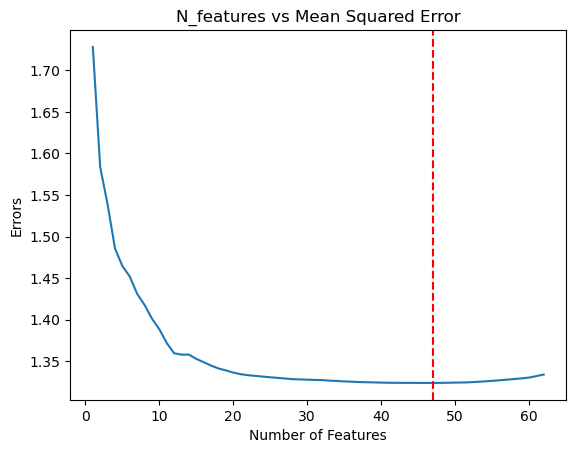

Best Number of Features:  47


In [42]:
#LIKE I SAID, DONT RUN THIS PART
#IT WILL GIVE YOU AN ERROR IF YOU DIDNT RUN THE PREVIOUS CHUNK 
#Find where the min error is so I can draw a line on the graph
min_index = np.argmin(cv_errors)
best_n_features = n_features[min_index]

#plot the graph so its easy to see
plt.plot(n_features, cv_errors)
plt.axvline(x = best_n_features, color = 'red', linestyle = '--')
plt.xlabel("Number of Features")
plt.ylabel("Errors")
plt.title("N_features vs Mean Squared Error")
plt.show()

print("Best Number of Features: ", best_n_features)

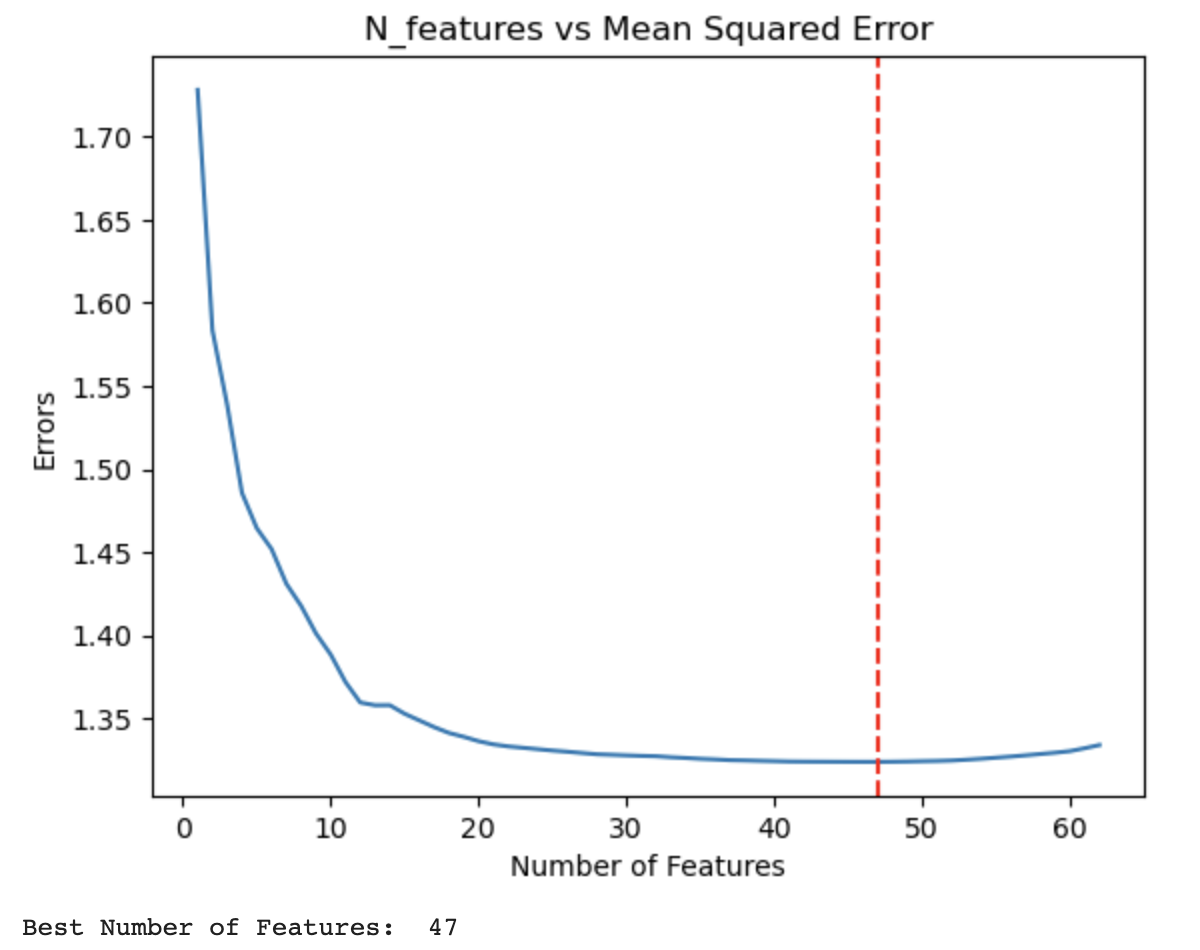

In [12]:
#import picture of output from previous chunks so you dont have to run the code
Image("Q1_feature_selection.png", width=500, height=500)

From this graph we can see which number of features gives us the minimum error. Therefore, For our final linear model, we will have 47 total features. 

In [119]:
#Now we will train a final linear model using the stepwise selection and 47 features
#will use same plain linear model from before to select the features
linear_model = LinearRegression()
sfs = SequentialFeatureSelector(linear_model, n_features_to_select = 47, direction = 'backward', 
                                scoring = 'neg_mean_squared_error', cv = 10)
sfs.fit(X_train_scaled, y_train)
X_train_selected = sfs.transform(X_train_scaled)
X_test_selected = sfs.transform(X_test_scaled)

#fit a tuned model on our selected features
tuned_linear = LinearRegression()
tuned_linear.fit(X_train_selected, y_train)

LinearRegression()

### 2.2 Regularized Regression
Our original dataset had over 60 predictors. It is possible that not all of these predictors are meaninful; there was evidence of this when we performed feature selection for the linear model.  Because of this, a regularized regression model might work well with our data. A ridge model works better than a Lasso when most of the predictors impact the response; we saw this was the case during feature selection (47 out of the 63 possible features were selected). Therefore, we will tune and train a Ridge model for our regularized regression. 

In [31]:
#your code here
#Do a Ridge model and use cv to determine the best value of alpha, use that value in the regression
#Using cross validation to ensure the best value of alpha and see which has the lowest error
#define the model and the parameters 
ridge_model = Ridge(random_state = seed)
parameters = {'alpha': np.logspace(-5, 10, 200)}

#use gridsearch to do hyperparameter tuning and fit the tuned model to our training data. 
ridge_model_tuned = GridSearchCV(ridge_model, parameters, cv = 10, scoring = 'neg_mean_squared_error')
ridge_model_tuned.fit(X_train_scaled, y_train)

#checking to see what the best alpha ended up being
print('Best alpha: ', ridge_model_tuned.best_params_)
print('Best score: ', np.abs(ridge_model_tuned.best_score_))

Best alpha:  {'alpha': 1.5885651294280527}
Best score:  1.368321734350755


### 2.3 Random Forest
Since we are also concerned about which features are most important in predicting life expectancy, a random forest is a great option because it will provide us with the feature importances. Therefore, we will now tune and train a random forest model. 

In [56]:
#identify the parameters to tune
#FYI: if you try to run this it will take several minutes
rf = RandomForestRegressor(random_state = seed)
parameters = {'n_estimators': [50, 100, 200, 300], 
              'max_features': ['sqrt', 'log2'],
              }


#using a cv of 10 and MSE as the scoring metric
rf_tuned = GridSearchCV(rf, parameters, cv=10, scoring = 'neg_mean_squared_error')
rf_tuned.fit(X_train_scaled, y_train)
print("------ Best Parameters  ----------")
print(rf_tuned.best_params_)
print("-------Best Score----------")
print(np.abs(rf_tuned.best_score_))

------ Best Parameters  ----------
{'max_features': 'sqrt', 'n_estimators': 100}
-------Best Score----------
0.9061044908427839


### 2.4 Gradient Boosting
After looking at the best cv scores for each model, the random forest has performed the best so far. This tells us that tree-based models are promising for our predictions. Therefore, for the additional model we will move away from bagging and look into boosting, specifically a gradient boosting model. We will again use gridsearchcv to perform hyperparameter tuning. 

In [59]:
#FYI: if you try to run this it will take a bit of time to run 
#initiate the model
gbr = GradientBoostingRegressor(random_state = seed)

#define parameters to tune
#since we are boosting, and our trees are not independent, 
#I will try one that is a subset and one that uses all for max_features parameter
parameters = {'n_estimators': [50, 100, 200], 
              'max_features': ['sqrt', 1.0],
              }

#using a cv of 10 and MSE as the scoring metric
gbr_tuned = GridSearchCV(rf, parameters, cv=10, scoring = 'neg_mean_squared_error')
gbr_tuned.fit(X_train_scaled, y_train)
print("------ Best Parameters  ----------")
print(gbr_tuned.best_params_)
print("-------Best Score----------")
print(np.abs(gbr_tuned.best_score_))

------ Best Parameters  ----------
{'max_features': 1.0, 'n_estimators': 200}
-------Best Score----------
0.7628995910902756


## 3. Model Selection
Now that we have properly tuned our models, we need to select a final model. In order to select a model, we need to cross validate to determine which model has the best performance (to prevent overfitting to our test set). To do this, we will run 10 fold cross validation and compare the average MSE. Then, we will choose the model with the lowest average MSE. 

In [203]:
#defining a function to print everything out
def model_performance(model):
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    print('-----------------------------')
    print("Training Performance")
    print('Training R-Squared: ', r2_score(y_train, y_pred_train))
    mse_train = mean_squared_error(y_train, y_pred_train)
    print('Training MSE: ', mse_train)
    print('---------------------------')
    print('Testing Performance')
    print('Testing R-Squared: ', r2_score(y_test, y_pred_test))
    mse_test = mean_squared_error(y_test, y_pred_test)
    print('Testing MSE: ', mse_test)
    print()
    print()
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)

In [204]:
#printing out all of the training and testing 
#had to separate linear bc of the selected features
lin_pred_train = tuned_linear.predict(X_train_selected)
lin_pred_test = tuned_linear.predict(X_test_selected)
print("Linear Model")
print('---------------------------')
print("Training Performance")
print('Training R-Squared: ', r2_score(y_train, lin_pred_train))
mse_train_lin = mean_squared_error(y_train, lin_pred_train)
print('Training MSE: ', mse_train_lin)
print('---------------------------')
print('Testing Performance')
print('Testing R-Squared: ', r2_score(y_test, lin_pred_test))
mse_test_lin = mean_squared_error(y_test, lin_pred_test)
print('Testing MSE: ', mean_squared_error(y_test, lin_pred_test))
print()
print()

mse_train_list = [mse_test_lin]
mse_test_list = [mse_train_lin]

models = {'Ridge Model': ridge_model_tuned, 'Random Forest': rf_tuned, 'Gradient Boost': gbr_tuned}
for key, value in models.items(): 
    print(key)
    model_performance(value)
    

Linear Model
---------------------------
Training Performance
Training R-Squared:  0.8663465354049692
Training MSE:  1.3163629977863827
---------------------------
Testing Performance
Testing R-Squared:  0.8896272302045594
Testing MSE:  1.047783246920342


Ridge Model
-----------------------------
Training Performance
Training R-Squared:  0.8667541407201407
Training MSE:  1.312348462463871
---------------------------
Testing Performance
Testing R-Squared:  0.8904864656909204
Testing MSE:  1.0396264112312756


Random Forest
-----------------------------
Training Performance
Training R-Squared:  0.9879471831774933
Training MSE:  0.1187090969345135
---------------------------
Testing Performance
Testing R-Squared:  0.9112859922891516
Testing MSE:  0.8421737645876197


Gradient Boost
-----------------------------
Training Performance
Training R-Squared:  0.9921647562843865
Training MSE:  0.07716990305581171
---------------------------
Testing Performance
Testing R-Squared:  0.7693314698008

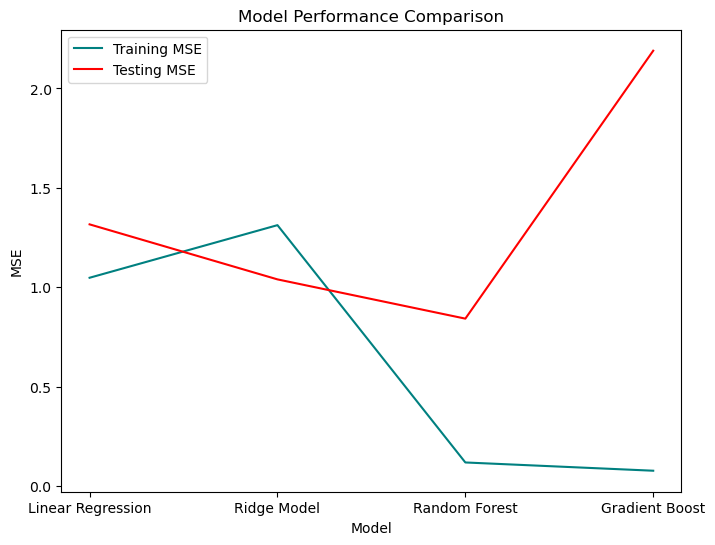

In [212]:
# Plotting the MSE values
xtick_labels = ['Linear Regression'] + list(models.keys())

plt.figure(figsize=(8,6))
plt.plot(mse_train_list, label='Training MSE', color = 'teal')
plt.plot(mse_test_list, label='Testing MSE', color = 'red')
plt.xticks(range(len(xtick_labels)), xtick_labels)
plt.legend()
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.show()

### Analyzing our results 



- **Linear Regression:** Our linear model performed the worst out of all four models with a testing r-squared of .89 and test MSE of 1.05. Something interesting about the linear model is that its performance improved for the testing set compared to the training set. 
- **Ridge Regression:** Our Ridge regression performed second-to-last out of all the models. Its testing r-squared was .89 and its testing MSE was 1.04. The ridge regression performed very similar to the linear regression and also improved on the test set compared to the training. 
- **Random Forest:** Our Random Forest did not perform the best on the training set, but did perform the best on the testing set. Its testing r-squared was .91 and its test MSE was .84. The random forest did do worse on the training set compared to the testing set, which is indicative of some overfitting. However, as mentioned, it performed the best overall on the test set (the lowest MSE and the higest r-squared). 
- **Gradient Boost:** Our gradient boost model performed the best on the training set with an r-squared of .99 and an MSE of .077. However, it appears this model overfit to the training data because the test r-squared is much lower (.769 compared to .99) and the MSE is much larger (2.19 compared to .077). 

Based on these results, **our best performing model is the Random Forest.** This model had the highest test r-squared and the lowest test MSE. 

## 4.  Final Model: Random Forest Regressor

Based on our previous analysis, our final model is the Random Forest Regressor. This helped us answer the first part of our question on how we can predict life expectancy. Now, to answer the second part of our question, we will examine which features were most influential in those predictions. 

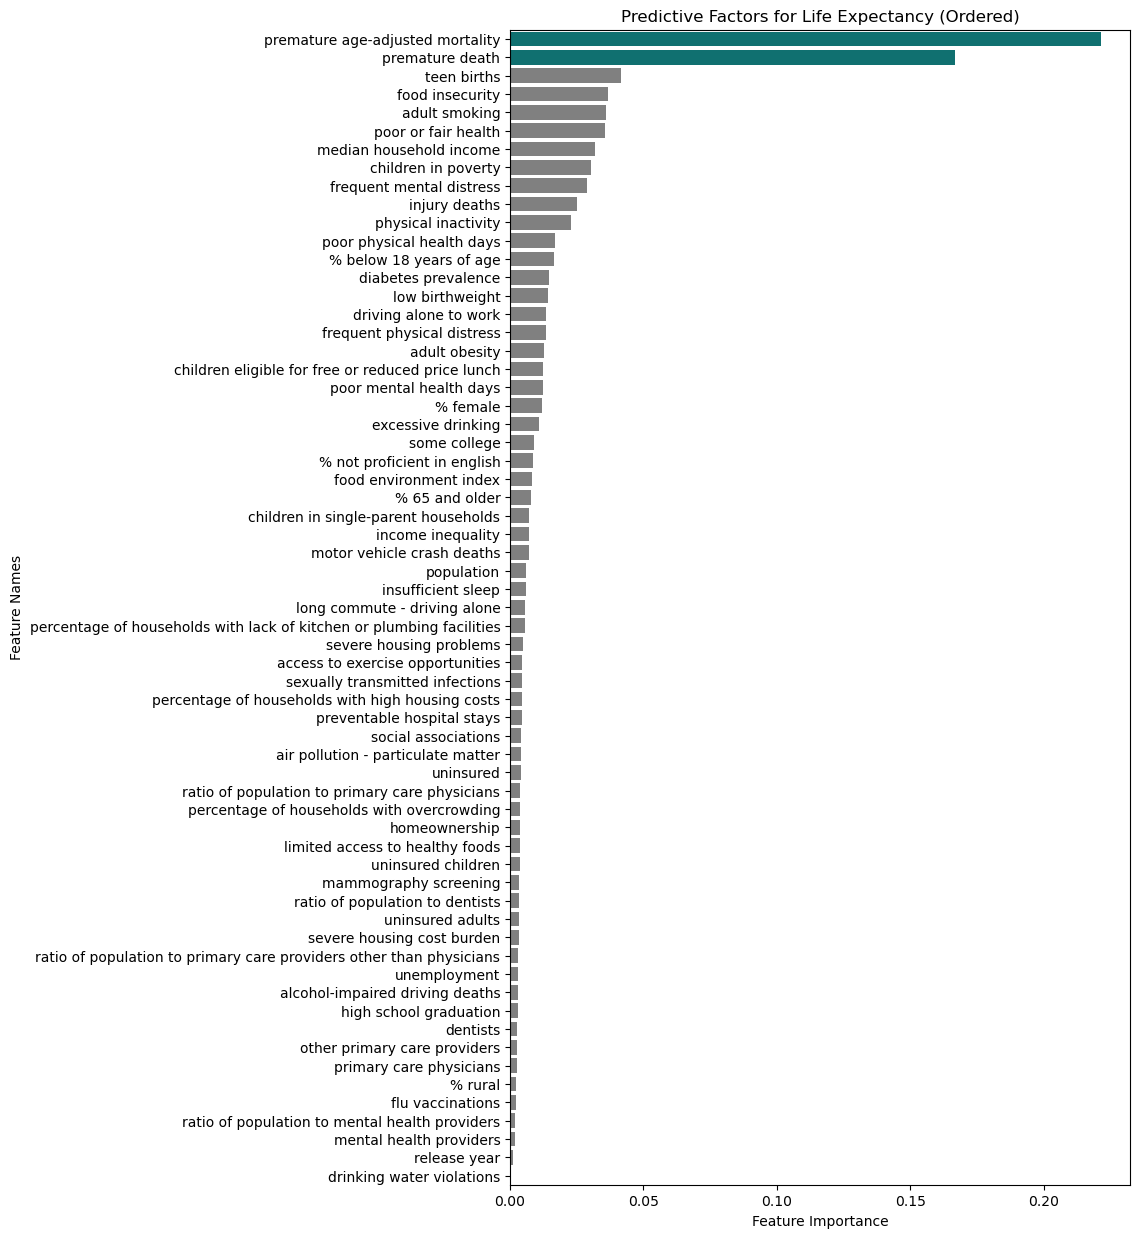

In [197]:
#Feature Importances 
#get the feature importances and put into df
importances = rf_tuned.best_estimator_.feature_importances_
fimp = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

#sort them by importance
fimp.sort_values(by=['Importance'], ascending=False,inplace=True)
#for plotting purposes Im removing the raw value part of the variable name
fimp['Feature'] = fimp['Feature'].str.replace('raw value', '').str.strip()

top2 = fimp.head(2)
top2

#creating custom pallete to make the top 10 values teal
cols = ['grey' if (x < min(top2['Importance'])) else 'teal' for x in fimp['Importance']]


#display
plt.figure(figsize=(8,15))
sns.barplot(x = 'Importance', y = 'Feature',data = fimp, palette = cols)
plt.title('Predictive Factors for Life Expectancy (Ordered)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.savefig('fimp1.png')

Since we did not remove premature age adjusted mortality and premature deaths from our dataset, these two are the most important features, which is not surprising (they were the 2 highest correlated variables with life expectancy; when you die directly impacts your life expectancy). Therefore, it will be more interesting to look at this graph without those two features. 

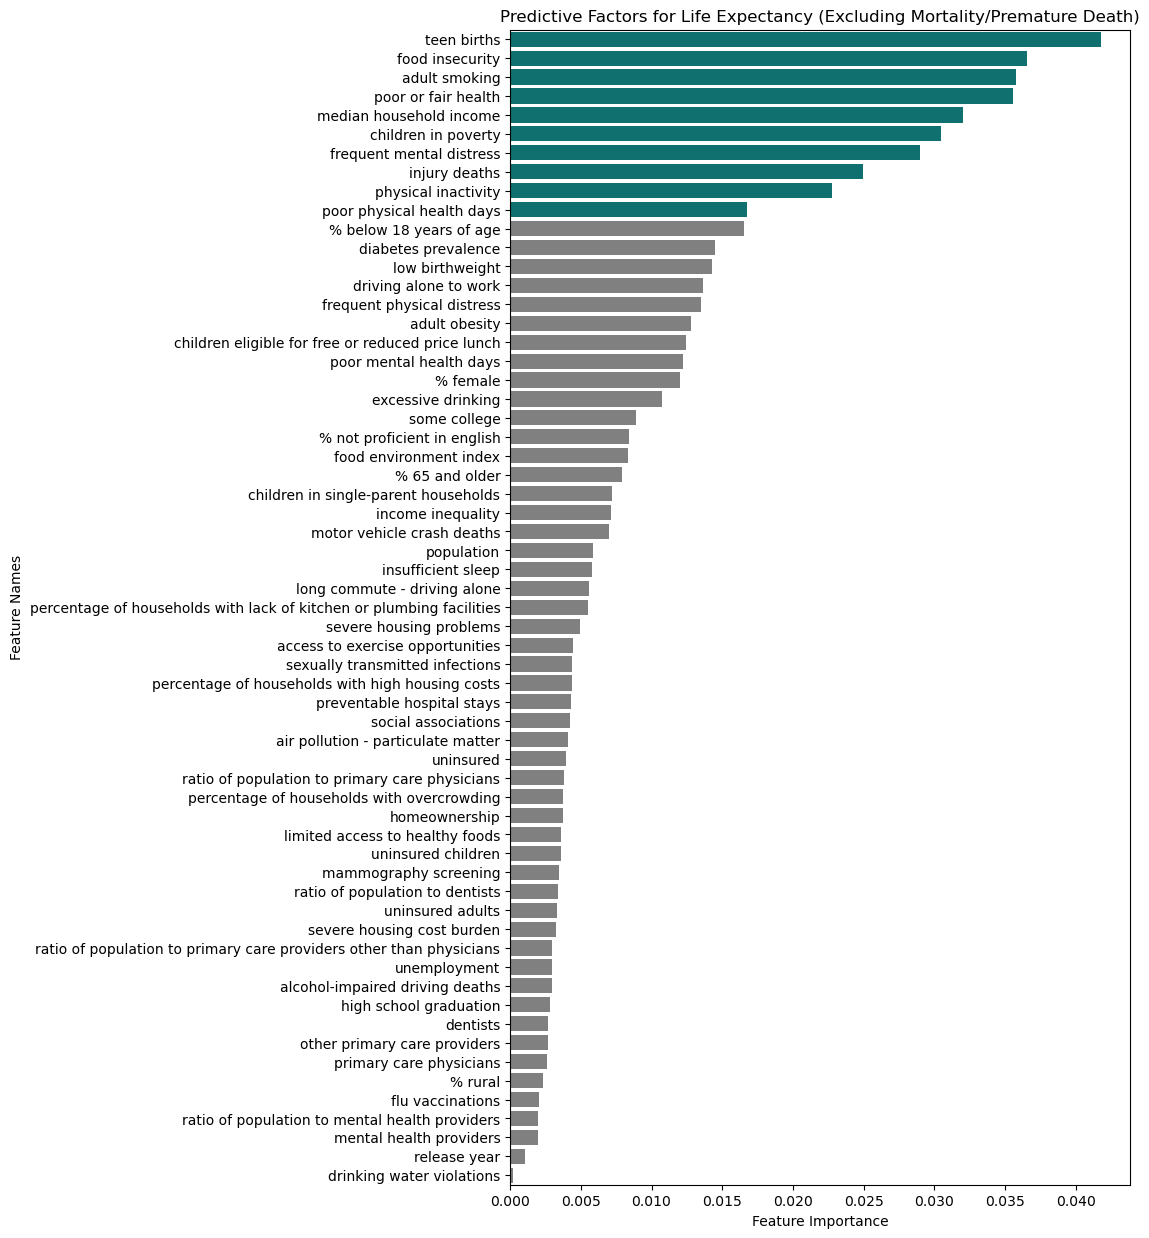

In [198]:
#now Im going to make the same graph, but without the age adjusted mortality and the premature deaths
#filter the data to remove those top 2 
fimp_filtered = fimp.iloc[2:]

#get the top 10 to use for color purposes
top10 = fimp_filtered.head(10)
top10

#creating custom pallete to make the top 10 values teal
cols = ['grey' if (x < min(top10['Importance'])) else 'teal' for x in fimp_filtered['Importance']]

#display
plt.figure(figsize = (8,15))
sns.barplot(x = 'Importance', y = 'Feature',data = fimp_filtered, palette = cols)
plt.title('Predictive Factors for Life Expectancy (Excluding Mortality/Premature Death)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.savefig('fimp2.png')

Text(0, 0.5, 'Feature Names')

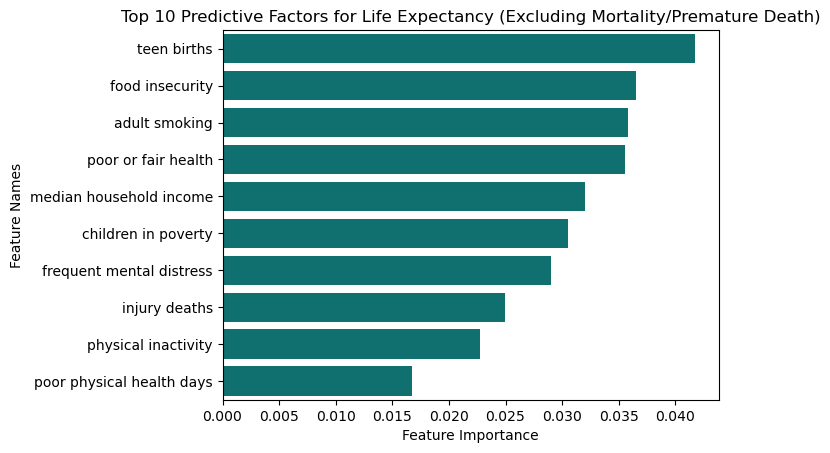

In [193]:
#Now lets take a closer look just at the top 10 (excluding premature deaths and mortality)
sns.barplot(x = 'Importance', y = 'Feature',data = top10, color = 'teal')
plt.title('Top 10 Predictive Factors for Life Expectancy (Excluding Mortality/Premature Death)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')

## Conclusions

**Research Question:** How can we predict life expectancy and which factors are most influential in this prediction? 

To answer the first part of our question, we tuned four different models (a linear regression, a ridge regression, a random forest regressor, and a Gradient Boost model). We then evaluated each tuned model and chose a final, best performing model. We found that the Random Forest Regressor performed the best. 

To answer the second part of our question, we looked at the feature importances from the random forest to examine which features were most influential in predicting life expectancy. We found that aside from the obvious best performing features (premature age adjusted mortality and premature deaths) the 3 most influential factors in determining life expectancy were the number of teen births, food insecurity, and adult smoking rates. 

**Policy Implications:** It is important to note that our results are not causal. However, the feature importances we found were very interesting. Some of our top features --such as adult smoking rates, injuries, and physical inactivity-- are factors that might have a direct impact on life expectancy. However, other factors seem to be more of secondary factors that impact health. For example, teen birth rates was one of the most important features in predicing life expectancy. However, this does not necesarily mean that the more teen births you have the lower your life expectancy. What is more likely is that there may be higher rates of teen births in lower-income areas with less access to healthcare or other resources, thus impacting life expectancy. Median household income and the childhood poverty rate were also among the top features in predicting life expectancy.

Therefore, Policy makers should not only target initiatives that directly impact health, but also emphasize policies to improve the socioeconomic status of their constituents, which may in turn improve overall health outcomes. 

**Future Work:** One obvious area for future work would be to remove the premature dealth and mortality rate features from our X set and see if the feature importance results are similar. Furthermore, our models are not causal, so further work could involve testing econometric models to determine the causaaility of our feature importance variables. Overall, our work has produced interesting conclusions, but can only provide insight for policymakers on where they can target their efforts. 

### References
- Midterm 
- Lectures 1-24
- Labs 1-11
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
- https://www.datacamp.com/tutorial/tutorial-ridge-lasso-elastic-net
- https://www.statology.org/seaborn-barplot-color/